In [4]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
from get_eval_classes import get_eval_classes

In [3]:
eval_labels, eval_label_names = get_eval_classes('cs', file_path = '../pre_process/labels.txt')

In [6]:
categories = {}
for i in range(len(eval_labels)):
    categories[eval_label_names[i]] = eval_labels[i]
categories

{'road': 7,
 'sidewalk': 8,
 'building': 11,
 'wall': 12,
 'fence': 13,
 'pole': 17,
 'traffic light': 19,
 'traffic sign': 20,
 'vegetation': 21,
 'terrain': 22,
 'sky': 23,
 'person': 24,
 'rider': 25,
 'car': 26,
 'truck': 27,
 'bus': 28,
 'train': 31,
 'motorcycle': 32,
 'bicycle': 33}

In [7]:
def cosine_distance_torch(x1, x2=None):
    x2 = x1 if x2 is None else x2
    return torch.mm(x1.to(float), x2.t().to(float))

In [39]:
def get_cosine_dist(model, categories):
    patch_features = np.load(f'../embeddings/cs_patches_256/layers/{model}_cs4pc_256_train_12_embeds.npy', allow_pickle=True)
    patch_labels = np.load(f'../embeddings/cs_patches_256/layers/{model}_cs4pc_256_train_labels.npy', allow_pickle=True)
    selected_patches = {}
    num_of_patches = None
    for c in categories.keys():
        patches = patch_features[np.where(patch_labels == categories[c])]
         [c] = patches
        
        if num_of_patches == None:
            num_of_patches = len(patches)
        else:
            num_of_patches = min(len(patches), num_of_patches)
    print(num_of_patches)
    
    cosine_distances = {}
    mean_std_matrixes = np.zeros(shape=(len(categories), len(categories), 2))
    
    for ind, c in enumerate(categories.keys()):
        for i, k in enumerate(categories.keys()):
            cosine_distances[f'{c}_{k}_{model}'] = np.array(cosine_distance_torch(torch.from_numpy(selected_patches[c][:num_of_patches]), torch.from_numpy(selected_patches[k][:num_of_patches])))
            mean_std_matrixes[ind][i] = np.array([np.mean(cosine_distances[f'{c}_{k}_{model}']), -np.std(cosine_distances[f'{c}_{k}_{model}'])])
            
    return cosine_distances, mean_std_matrixes

165


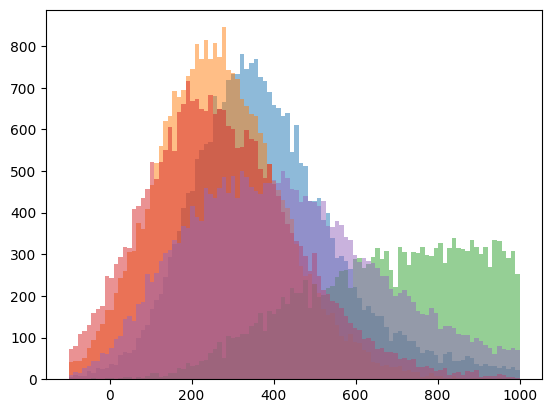

In [40]:
model='dinov2'
cd_dinov2, ms_dinov2 = get_cosine_dist(model, categories)
selected_pairs = [f'car_car_{model}', f'car_bus_{model}', f'car_truck_{model}', f'car_person_{model}', f'car_fence_{model}']
for pair in cd_dinov2.keys():
    if pair in selected_pairs:
        plt.hist(cd_dinov2[pair].flatten(), bins=100, range=(-100, 1000), alpha=0.5, label=pair)

In [10]:
means_dinov2 = ms_dinov2[:, :, :1]
std_dinov2 = ms_dinov2[:, :, -1:]

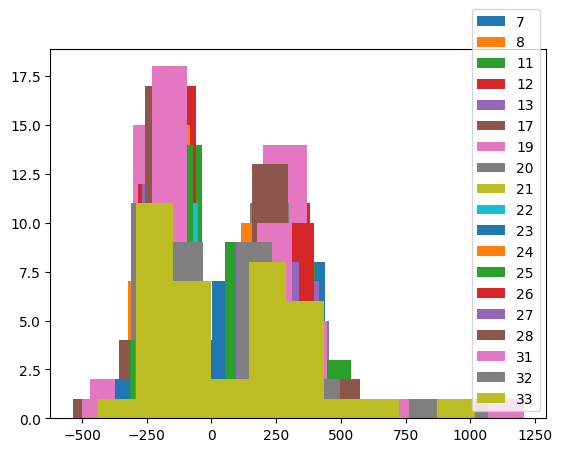

In [44]:
for ms in range(len(ms_dinov2)):
    plt.hist(ms_dinov2[ms].flatten(), bins=10, label=eval_labels[ms])
plt.legend()

In [33]:
ms_dinov2[0].flatten()

array([1071.96465931,  513.94064416,  676.12112531,  347.70896969,
        178.71706789,  123.70272186,  270.70299282,  132.34375743,
        322.56412053,  203.51899598,  302.79118023,  175.73478356,
        315.08702768,  142.67003585,  300.71371116,  165.11750641,
        168.48662673,  162.73122351,  352.42730758,  209.31863566,
        307.27233083,  256.71887143,  149.37790714,  180.50765578,
        163.16688632,  182.66772049,  293.25886293,  193.08862537,
         60.56434136,  141.3866305 ,  235.81582283,  161.32419876,
        277.28099991,  187.16083233,  190.9501266 ,  175.42224397,
        296.17659675,  190.6426053 ])

In [11]:
std_dinov2

array([[[513.94064416],
        [347.70896969],
        [123.70272186],
        [132.34375743],
        [203.51899598],
        [175.73478356],
        [142.67003585],
        [165.11750641],
        [162.73122351],
        [209.31863566],
        [256.71887143],
        [180.50765578],
        [182.66772049],
        [193.08862537],
        [141.3866305 ],
        [161.32419876],
        [187.16083233],
        [175.42224397],
        [190.6426053 ]],

       [[347.70896969],
        [458.22651781],
        [147.34412114],
        [158.12628945],
        [222.42831981],
        [239.34353868],
        [182.76187978],
        [177.74509187],
        [153.89599939],
        [239.57757405],
        [159.60007886],
        [212.9266707 ],
        [195.2662858 ],
        [191.93539603],
        [168.56250135],
        [121.61138671],
        [169.78261179],
        [180.86985857],
        [186.30750122]],

       [[123.70272186],
        [147.34412114],
        [473.56008761],
        [157

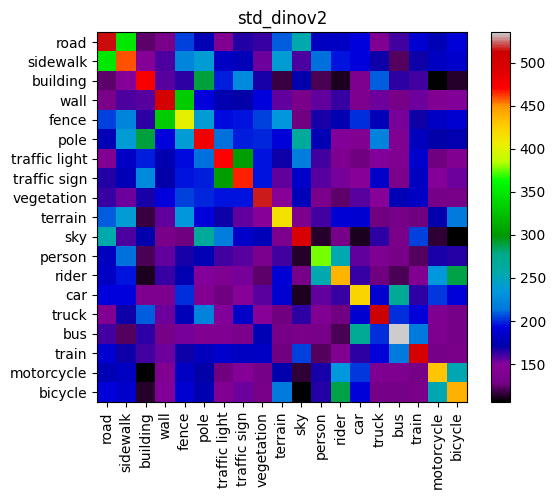

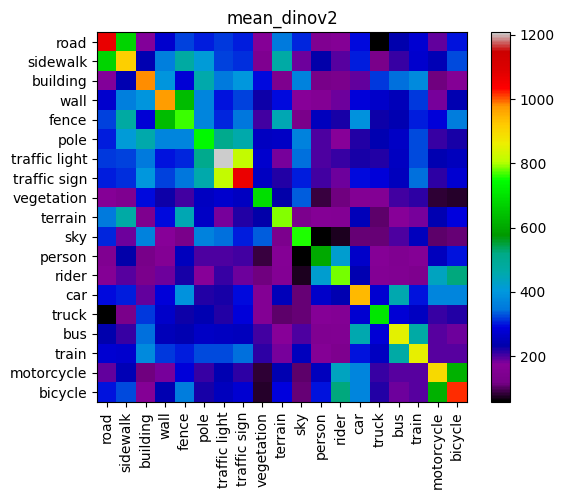

In [91]:
plt.imshow(np.array(std_dinov2), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'std_{model}')
plt.show()
plt.imshow(np.array(means_dinov2), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'mean_{model}')

plt.show()

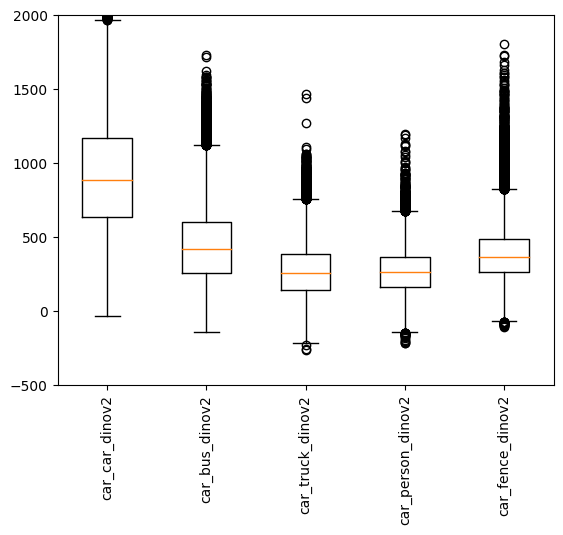

In [18]:
plt.figure()
plt.boxplot([cd_dinov2[pair].flatten() for pair in selected_pairs]);
plt.xticks(range(1,6), selected_pairs, rotation=90)
plt.ylim(-500, 2000);

In [ ]:
plt.figure()
plt.boxplot([cd_dinov2 for pair in selected_pairs]);
plt.xticks(range(1,6), selected_pairs, rotation=90)
plt.ylim(-500, 2000);

134


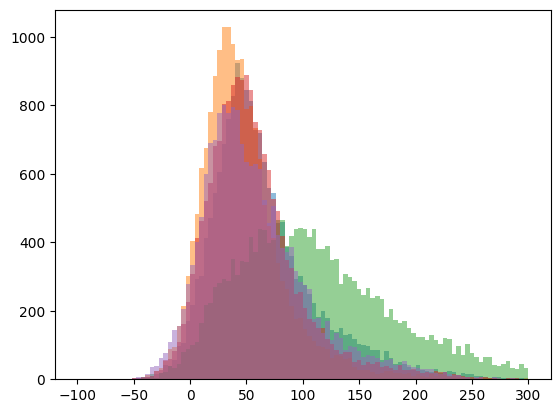

In [92]:
model='sup_vit'
cd_vit, ms_vit = get_cosine_dist(model, categories)
selected_pairs = [f'car_car_{model}', f'car_bus_{model}', f'car_truck_{model}', f'car_person_{model}', f'car_fence_{model}']
for pair in cd_vit.keys():
    if pair in selected_pairs:
        plt.hist(cd_vit[pair].flatten(), bins=100, range=(-100, 300), alpha=0.5, label=pair)

In [93]:
means_vit = ms_vit[:, :, :1]
std_vit = ms_vit[:, :, -1:]

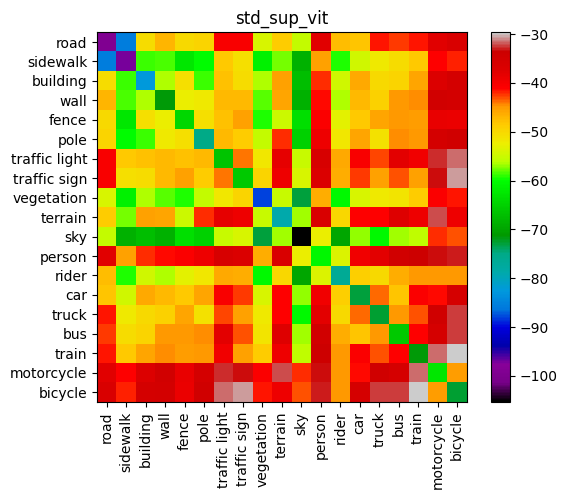

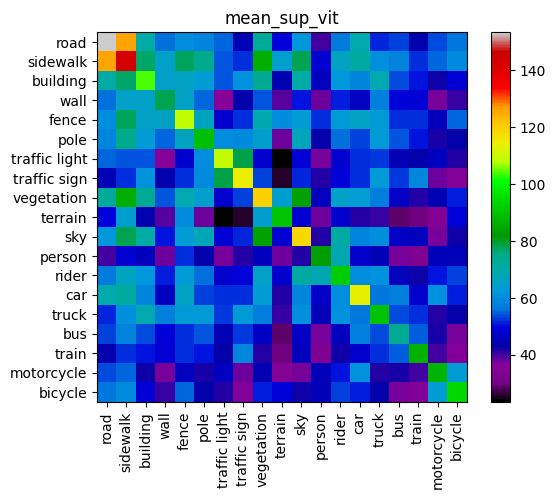

In [94]:
plt.imshow(np.array(std_vit), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'std_{model}')
plt.show()
plt.imshow(np.array(means_vit), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'mean_{model}')

plt.show()

In [ ]:
plt.figure()
plt.boxplot([cd_vit[pair].flatten() for pair in selected_pairs]);
plt.xticks(range(1,6), selected_pairs, rotation=90)
plt.ylim(-500, 2000);

134


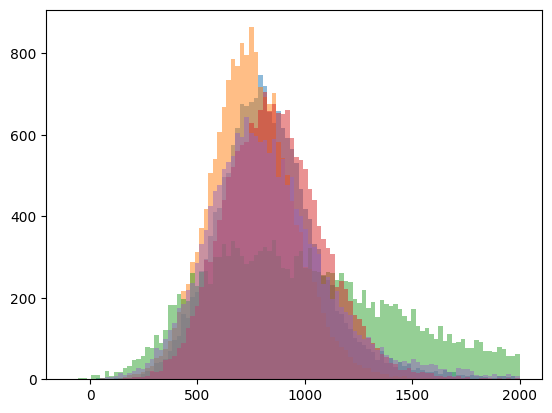

In [95]:
model='dino'
cd_dino, ms_dino = get_cosine_dist(model, categories)
selected_pairs = [f'car_car_{model}', f'car_bus_{model}', f'car_truck_{model}', f'car_person_{model}', f'car_fence_{model}']
for pair in cd_dino.keys():
    if pair in selected_pairs:
        plt.hist(cd_dino[pair].flatten(), bins=100, range=(-100, 2000), alpha=0.5, label=pair)

In [96]:
means_dino = ms_dino[:, :, :1]
std_dino = ms_dino[:, :, -1:]

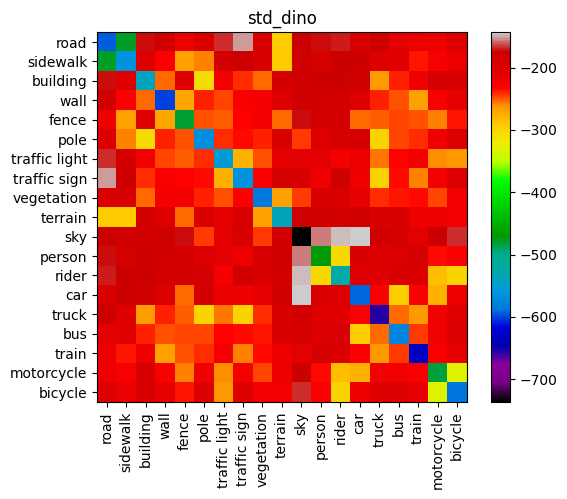

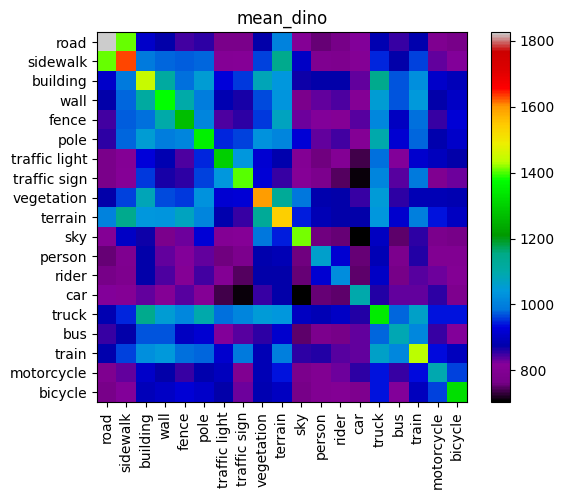

In [97]:
plt.imshow(np.array(std_dino), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'std_{model}')
plt.show()
plt.imshow(np.array(means_dino), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'mean_{model}')

plt.show()

In [ ]:
plt.figure()
plt.boxplot([cd_dino[pair].flatten() for pair in selected_pairs]);
plt.xticks(range(1,6), selected_pairs, rotation=90)
plt.ylim(-500, 2000);

134


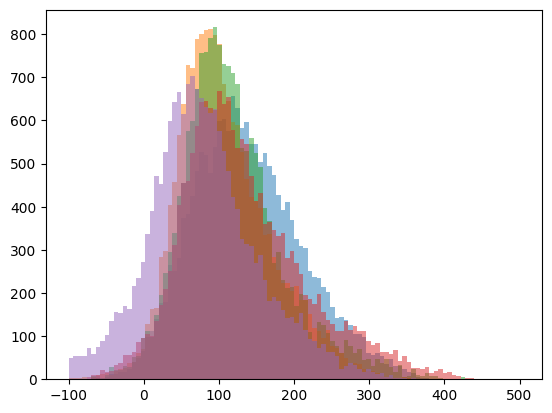

In [98]:
model='mae'
cd_mae, ms_mae = get_cosine_dist(model, categories)
selected_pairs = [f'car_car_{model}', f'car_bus_{model}', f'car_truck_{model}', f'car_person_{model}', f'car_fence_{model}']
for pair in cd_mae.keys():
    if pair in selected_pairs:
        plt.hist(cd_mae[pair].flatten(), bins=100, range=(-100, 500), alpha=0.5, label=pair)

In [99]:
means_mae = ms_mae[:, :, :1]
std_mae = ms_mae[:, :, -1:]

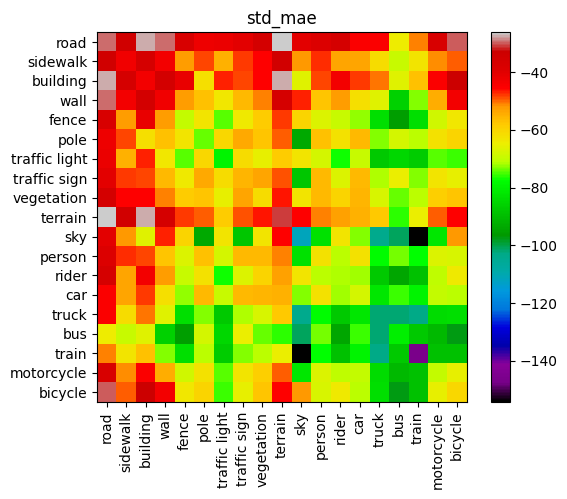

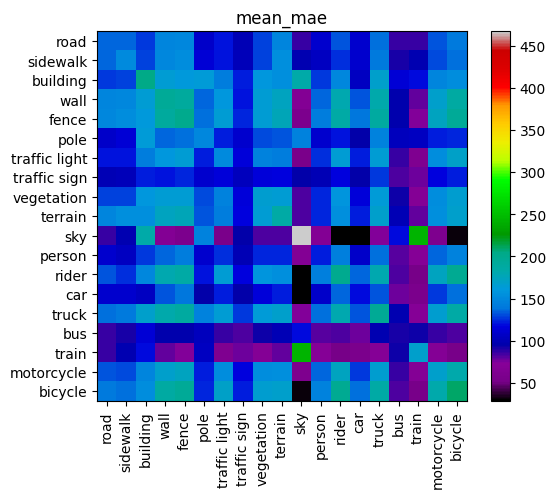

In [100]:
plt.imshow(np.array(std_mae), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'std_{model}')
plt.show()
plt.imshow(np.array(means_mae), cmap='nipy_spectral')
plt.yticks(range(len(eval_labels)), eval_label_names)
plt.xticks(range(len(eval_labels)), eval_label_names, rotation=90)

plt.colorbar()
plt.title(f'mean_{model}')

plt.show()

In [ ]:
plt.figure()
plt.boxplot([cd_mae[pair].flatten() for pair in selected_pairs]);
plt.xticks(range(1,6), selected_pairs, rotation=90)
plt.ylim(-500, 2000);

In [46]:
mean_std_dinov2 = {}
for dist in cd_dinov2.keys():
    mean = np.mean(cd_dinov2[dist])
    std = np.std(cd_dinov2[dist])
    mean_std_dinov2[dist] = np.array([mean, -std])

In [27]:
cd_dinov2['road_road_dinov2'][0].shape

(165,)

In [24]:
mean_std_dinov2['road_road_dinov2'].flatten()

array([1071.96465931, -513.94064416])

In [78]:
label_to_color= {"0": [0, 0, 0], "1": [0, 0, 0], "2": [0, 0, 0], "3": [0, 0, 0], "4": [0, 0, 0], "5": [111, 74, 0], "6": [81, 0, 81], "7": [128, 64, 128], "8": [244, 35, 232], "9": [250, 170, 160], "10": [230, 150, 140], "11": [70, 70, 70], "12": [102, 102, 156], "13": [190, 153, 153], "14": [180, 165, 180], "15": [150, 100, 100], "16": [150, 120, 90], "17": [153, 153, 153], "18": [153, 153, 153], "19": [250, 170, 30], "20": [220, 220, 0], "21": [107, 142, 35], "22": [152, 251, 152], "23": [70, 130, 180], "24": [220, 20, 60], "25": [255, 0, 0], "26": [0, 0, 142], "27": [0, 0, 70], "28": [0, 60, 100], "29": [0, 0, 90], "30": [0, 0, 110], "31": [0, 80, 100], "32": [0, 0, 230], "33": [119, 11, 32]}

[0.5  0.25 0.5 ]
[0.953125   0.13671875 0.90625   ]
[0.2734375 0.2734375 0.2734375]
[0.3984375 0.3984375 0.609375 ]
[0.7421875  0.59765625 0.59765625]
[0.59765625 0.59765625 0.59765625]
[0.9765625 0.6640625 0.1171875]
[0.859375 0.859375 0.      ]
[0.41796875 0.5546875  0.13671875]
[0.59375    0.98046875 0.59375   ]
[0.2734375 0.5078125 0.703125 ]
[0.859375 0.078125 0.234375]
[0.99609375 0.         0.        ]
[0.        0.        0.5546875]
[0.        0.        0.2734375]
[0.       0.234375 0.390625]
[0.       0.3125   0.390625]
[0.        0.        0.8984375]
[0.46484375 0.04296875 0.125     ]


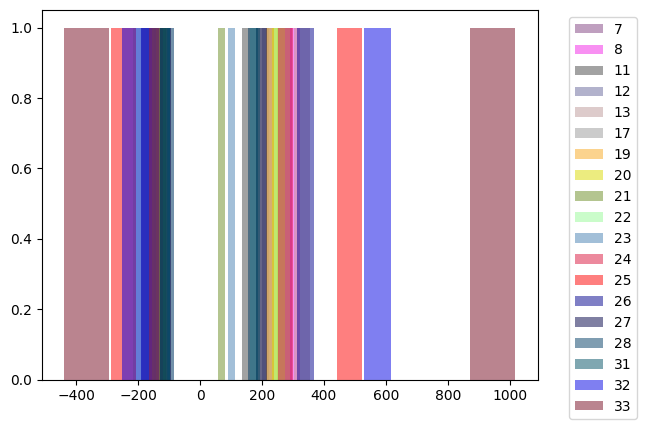

In [90]:
for pair in mean_std_dinov2.keys():
    if pair.split('_')[0] == 'bicycle':
        color = np.array(label_to_color[str(categories[pair.split('_')[1]])])/256
        print(color)
        plt.hist(mean_std_dinov2[pair], alpha=0.5, color=color, label=categories[pair.split('_')[1]])
        
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [89]:
np.array([1, 2, 3])/256

array([0.00390625, 0.0078125 , 0.01171875])

In [ ]:
mean_std_dinov2_matrix = []
for ind, key in enumerate(cd_dinov2.keys()):
    print(dist)
    mean = np.mean(cd_dinov2[dist])
    std = np.std(cd_dinov2[dist])
    mean_std_dinov2[dist] = np.array([mean, -std])

In [ ]:
a, b in enumerate(cd_dinov2.keys())

In [1]:
import clip

In [2]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
train_embeds = np.load('/home/hkhachatrian/mae/embeddings/cs_patches_256/mae_cs4pc_256_train_2_embeds.npy', allow_pickle=True)

In [6]:
train_embeds.shape

(225792, 768)